### Mobile Rating Prediction


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings
from sklearn.datasets import make_blobs
from tqdm import tqdm_notebook
np.random.seed(0)
warnings.filterwarnings('ignore')
Threshold = 4

In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 99 columns):
PhoneId                                        355 non-null int64
Also Known As                                  17 non-null object
Applications                                   43 non-null object
Architecture                                   273 non-null object
Aspect Ratio                                   204 non-null object
Audio Features                                 30 non-null object
Audio Jack                                     343 non-null object
Autofocus                                      333 non-null object
Bezel-less display                             154 non-null object
Bluetooth                                      351 non-null object
Brand                                          354 non-null object
Browser                                        23 non-null object
Build Material                                 102 non-null object
Camera Features              

In [4]:
test = pd.read_csv('./data/test.csv')

## train shape and test shape 

In [5]:
print(f'no of rows : {train.shape[0]}')
print(f'no of features :{train.shape[1]}')
print(f'no of rows : {test.shape[0]}')
print(f'no of feature {test.shape[1]}')

no of rows : 355
no of features :99
no of rows : 119
no of feature 98


In [6]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

## Removing  features


In [7]:
train = data_clean(train)
test = data_clean(test)

### removing all data rows where we have missing more than  alimit features

In [8]:
train = train[(train.isnull().sum(axis =1) <= 15)]

In [9]:
print(f'No of rows:{train.shape[0]}')
print(f'No of feature:{train.shape[1]}')
print(f'No of rows:{test.shape[0]}')
print(f'No of feature:{test.shape[1]}')

No of rows:341
No of feature:47
No of rows:119
No of feature:46


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 0 to 354
Data columns (total 47 columns):
Type                                 340 non-null object
Internal Memory                      334 non-null object
Bezel-less display                   154 non-null object
Brand                                341 non-null object
Expandable Memory                    341 non-null object
Weight                               317 non-null object
Screen Size                          341 non-null object
Graphics                             325 non-null object
Resolution                           341 non-null object
SIM 2                                312 non-null object
Other Sensors                        331 non-null object
Review Count                         341 non-null int64
User Available Storage               149 non-null object
Display Type                         341 non-null object
Browser                              13 non-null object
Capacity                             341 n

## Filling Missing Values

In [11]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [12]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [13]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 0 to 354
Data columns (total 51 columns):
Type                                 341 non-null object
Internal Memory                      341 non-null int32
Bezel-less display                   154 non-null object
Brand                                341 non-null object
Expandable Memory                    341 non-null object
Weight                               341 non-null int32
Screen Size                          341 non-null float64
Graphics                             325 non-null object
Resolution                           341 non-null int32
SIM 2                                341 non-null object
Other Sensors                        331 non-null object
Review Count                         341 non-null int64
User Available Storage               149 non-null object
Display Type                         341 non-null object
Browser                              13 non-null object
Capacity                             341 non

### Not very important

In [15]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [16]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 0 to 354
Data columns (total 18 columns):
Sim1                                 341 non-null object
Internal Memory                      341 non-null int32
Processor_frequency                  341 non-null float64
Capacity                             341 non-null int64
Pixel Density                        341 non-null int64
Brand                                341 non-null object
Weight                               341 non-null int32
Screen Size                          341 non-null float64
Height                               341 non-null float64
SIM Slot(s)                          341 non-null object
Num_cores                            341 non-null object
PhoneId                              341 non-null int64
Screen to Body Ratio (calculated)    341 non-null float64
SIM 2                                341 non-null object
Resolution                           341 non-null int32
Rating                               341 n

In [18]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Sim1', 'Internal Memory', 'Processor_frequency', 'Capacity',
       'Pixel Density', 'Brand', 'Weight', 'Screen Size', 'Height',
       'SIM Slot(s)', 'Num_cores', 'Screen to Body Ratio (calculated)',
       'SIM 2', 'Resolution', 'RAM', 'os_name'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Internal Memory', 'Processor_frequency', 'Capacity',
       'Pixel Density', 'Weight', 'Screen Size', 'Height',
       'Screen to Body Ratio (calculated)', 'Resolution', 'RAM', 'Sim1_2G',
       'Sim1_3G', 'Sim1_4G', 'Brand_10.or', 'Brand_Apple', 'Brand_Asus',
       'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio', 'Brand_Coolpad',
       'Brand_Do', 'Brand_Gionee', 'Brand_Google', 'Brand_HTC', 'Brand_Honor',
       'Brand_Huawei', 'Brand_InFocus', 'Brand_Infinix', 'Brand_Intex',
       'Brand_Itel', 'Brand_Jivi', 'Brand_Karbonn', 'Brand_LG', 'Brand_Lava',
       'Brand_LeEco', 'Brand_Lenovo', 'Brand_Lephone', 'Brand_Lyf',
       'Brand_Meizu', 'Brand_Microma

In [19]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [20]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


In [21]:
train_new.head()

,PhoneId,Internal Memory,Processor_frequency,Capacity,Pixel Density,Weight,Screen Size,Height,Screen to Body Ratio (calculated),Resolution,...,SIM 2_4G,SIM 2_Other,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Rating
0,0,64,1.8,4000,403,182,6.26,157.9,80.68,20,...,1,0,1,0,0,0,0,0,0,4.5
1,1,32,1.8,4230,271,168,6.20,156.2,80.85,8,...,1,0,1,0,0,0,0,0,0,4.5
2,2,32,2.1,3500,409,168,6.30,157.0,83.68,25,...,1,0,1,0,0,0,0,0,0,4.4
3,4,64,2.2,3300,411,169,6.00,159.8,74.78,24,...,1,0,1,0,0,0,0,0,0,4.3
4,5,64,2.2,3750,396,175,6.50,160.4,84.23,16,...,1,0,1,0,0,0,0,0,0,4.4


In [22]:
test_new.head()

,PhoneId,Internal Memory,Processor_frequency,Capacity,Pixel Density,Weight,Screen Size,Height,Screen to Body Ratio (calculated),Resolution,...,SIM 2_3G,SIM 2_4G,SIM 2_Other,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS
0,3,16,1.8,4230,271,168,6.20,156.2,80.85,5,...,0,1,0,1,0,0,0,0,0,0
1,11,64,1.8,5000,402,205,6.20,156.0,81.60,12,...,0,1,0,1,0,0,0,0,0,0
2,13,64,2.0,3500,409,169,6.30,156.7,83.84,25,...,0,1,0,1,0,0,0,0,0,0
3,16,64,2.0,3500,409,169,6.30,156.7,83.84,16,...,0,1,0,1,0,0,0,0,0,0
4,19,64,1.8,4000,403,181,5.99,158.6,77.43,20,...,0,1,0,1,0,0,0,0,0,0


In [23]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 0 to 340
Data columns (total 88 columns):
PhoneId                                      341 non-null int64
Internal Memory                              341 non-null int32
Processor_frequency                          341 non-null float64
Capacity                                     341 non-null int64
Pixel Density                                341 non-null int64
Weight                                       341 non-null int32
Screen Size                                  341 non-null float64
Height                                       341 non-null float64
Screen to Body Ratio (calculated)            341 non-null float64
Resolution                                   341 non-null int32
RAM                                          341 non-null int32
Sim1_2G                                      341 non-null uint8
Sim1_3G                                      341 non-null uint8
Sim1_4G                                      341 non-nu

In [24]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 87 columns):
PhoneId                                      119 non-null int64
Internal Memory                              119 non-null int32
Processor_frequency                          119 non-null float64
Capacity                                     119 non-null int64
Pixel Density                                119 non-null int64
Weight                                       119 non-null int32
Screen Size                                  119 non-null float64
Height                                       119 non-null float64
Screen to Body Ratio (calculated)            119 non-null float64
Resolution                                   119 non-null int32
RAM                                          119 non-null int32
Sim1_2G                                      119 non-null uint8
Sim1_3G                                      119 non-null uint8
Sim1_4G                                      119 non-nu

## Model

In [25]:
class MPNeuron:
    
    def __init__(self):
        self.b = None
    
    def model(self, x):
        return (sum(x) >= self.b )
    
    def predict(self,X):
        Y_pred = []
        for x in X:
            y_pred=self.model(x)
            Y_pred.append(y_pred)
        return np.array(Y_pred)
    
    def fit(self,X,Y):
        accuracy = {}
        
        for b in range(X.shape[1]+1):
            self.b = b
            Y_pred = self.predict(X)
            accuracy[b] = accuracy_score(Y, Y_pred)
            
        best_b = max(accuracy, key= accuracy.get)
        self.b = best_b
        
        print(f' B value : {self.b}')
        print(f'accuracy : {accuracy[best_b]}')

In [26]:
import seaborn as sns

In [27]:
train_new_1 = train_new.copy()
test_new_1 = test_new.copy()

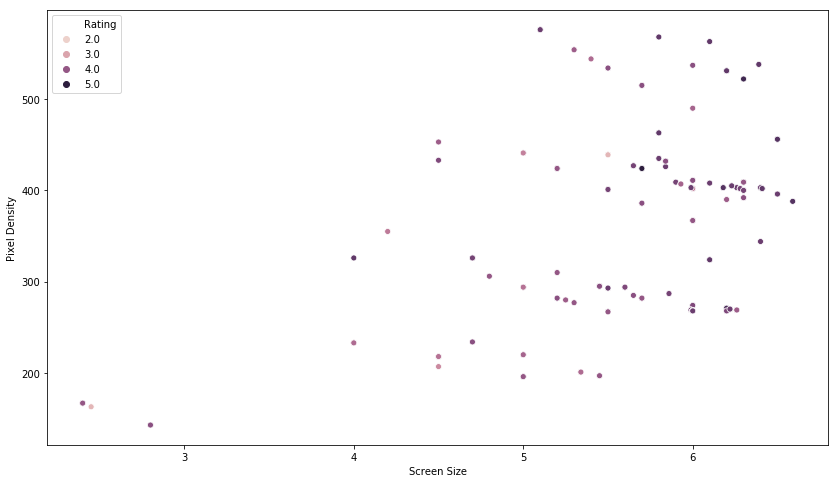

In [28]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='Screen Size', y='Pixel Density', hue='Rating', data= train_new)

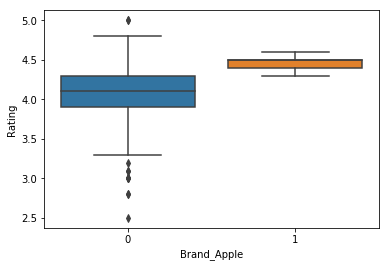

In [29]:
sns.boxplot('Brand_Apple', 'Rating', data=train_new)

### here as brandname apple have more good rating

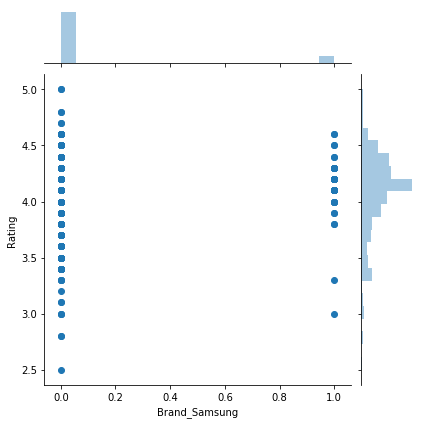

In [30]:
sns.jointplot('Brand_Samsung', 'Rating', data=train_new)

### samsung have mix rating

<Figure size 3600x504 with 0 Axes>

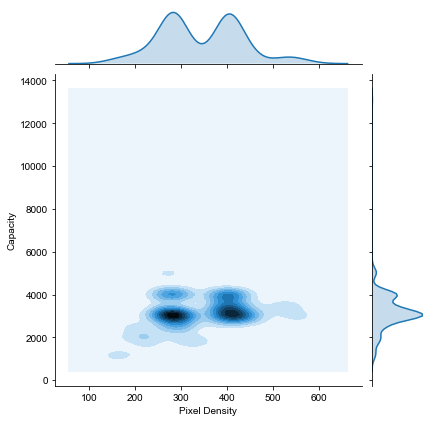

<Figure size 3600x504 with 0 Axes>

In [31]:
sns.jointplot('Pixel Density', 'Capacity'  ,data= train_new, kind='kde')
sns.set_style(style='darkgrid')
sns.axes_style(style='darkgrid')
plt.figure(figsize=(50,7))

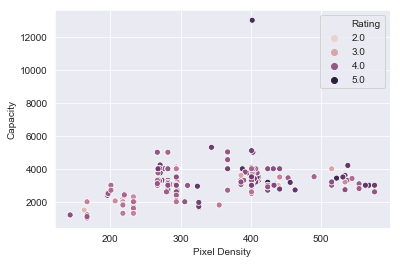

In [32]:
sns.scatterplot(x='Pixel Density', y='Capacity', hue='Rating', data=train_new)

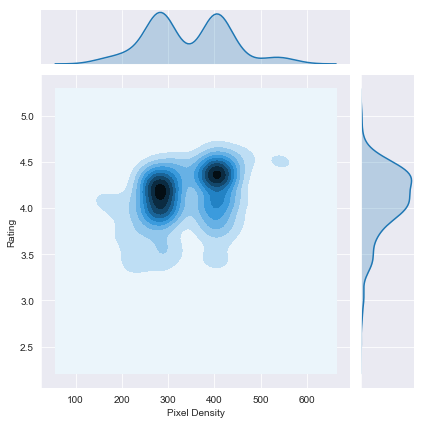

In [33]:
sns.jointplot("Pixel Density", "Rating", data=train_new, kind='kde' )

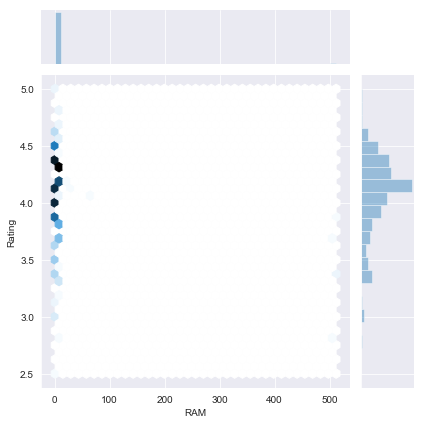

In [34]:
sns.jointplot("RAM", "Rating", data=train_new, kind="hex")

In [ ]:
sns.pairplot(data= train_new.iloc[:,[1,2,3,4,87]], hue='Rating' )

## Checking Correlation


In [31]:
train_corr = train_new.iloc[:,[0,1,2,3,4,5,6,7,8,9]]
train_corr.head()

,PhoneId,Processor_frequency,Resolution,Pixel Density,Screen Size,Capacity,Weight,RAM,Internal Memory,Height
0,0,1.8,20,403,6.26,4000,182,4,64,157.9
1,1,1.8,8,271,6.20,4230,168,3,32,156.2
2,2,2.1,25,409,6.30,3500,168,3,32,157.0
3,4,2.2,24,411,6.00,3300,169,4,64,159.8
4,5,2.2,16,396,6.50,3750,175,4,64,160.4


In [32]:
correlations = train_corr.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

correlations.tail(10)

,level_0,level_1,0
80,Capacity,Height,0.635365
81,Height,Capacity,0.635365
82,Pixel Density,Processor_frequency,0.639060
83,Processor_frequency,Pixel Density,0.639060
84,Weight,Height,0.642595
85,Height,Weight,0.642595
86,Capacity,Weight,0.687891
87,Weight,Capacity,0.687891
88,Screen Size,Height,0.861143
89,Height,Screen Size,0.861143


In [33]:
def rating(x):
    return 1 if (x >= 4.0 ) else 0
train_new['Rating'] = train_new['Rating'].apply(rating,)
def RAM(x):
    if x >= 2 : #x >= 6
        return 1
    else:
        return 0

train_new['RAM'] = train_new['RAM'].apply(RAM)
test_new['RAM'] = test_new['RAM'].apply(RAM)
def Height(x):
    if x >= 136.5: #x >= 150
        return 1
    else:
        return 0
    
train_new['Height'] = train_new['Height'].apply(Height)
test_new['Height'] = test_new['Height'].apply(Height)
def Processor_frequency(x):
    if x >= 1.4: #x > 1.5
        return 1
    else:
        return 0
    
train_new['Processor_frequency'] = train_new['Processor_frequency'].apply(Processor_frequency)
test_new['Processor_frequency'] = test_new['Processor_frequency'].apply(Processor_frequency)
def Capacity(x):
    if x >= 2350: #x >= 4100
        return 1
    else:
        return 0 
    
train_new['Capacity'] = train_new['Capacity'].apply(Capacity)
test_new['Capacity'] = test_new['Capacity'].apply(Capacity)
def Pixel_Density(x):
    if x >= 234: #x >= 271
        return 1
    else:
        return 0

train_new['Pixel Density'] = train_new['Pixel Density'].apply(Pixel_Density)
test_new['Pixel Density'] = test_new['Pixel Density'].apply(Pixel_Density)
def Resolution(x):
    if x >= 5: # x > 8 
        return 1
    else:
        return 0
    
train_new['Resolution'] = train_new['Resolution'].apply(Resolution)
test_new['Resolution'] = test_new['Resolution'].apply(Resolution)
def Weight(x):
    if x >= 129: # x > 164
        return 1
    else:
        return 0
    
train_new['Weight'] = train_new['Weight'].apply(Weight)
test_new['Weight'] = test_new['Weight'].apply(Weight)
def Screen_to_Body_Ratio(x):
    if x >= 65.23 : #x > 65.47
        return 1
    else:
        return 0
    
train_new['Screen to Body Ratio (calculated)'] = train_new['Screen to Body Ratio (calculated)'].apply(Screen_to_Body_Ratio)
test_new['Screen to Body Ratio (calculated)'] = test_new['Screen to Body Ratio (calculated)'].apply(Screen_to_Body_Ratio)
def Screen_Size(x):
    if x >= 4.7: #x > 5.5
        return 1
    else:
        return 0
    
train_new['Screen Size'] = train_new['Screen Size'].apply(Screen_Size)
test_new['Screen Size'] = test_new['Screen Size'].apply(Screen_Size)
def Internal_memory(x):
    if x >= 16: #x >= 32
        return 1
    else:
        return 0
    
train_new['Internal Memory'] = train_new['Internal Memory'].apply(Internal_memory)
test_new['Internal Memory'] = test_new['Internal Memory'].apply(Internal_memory)

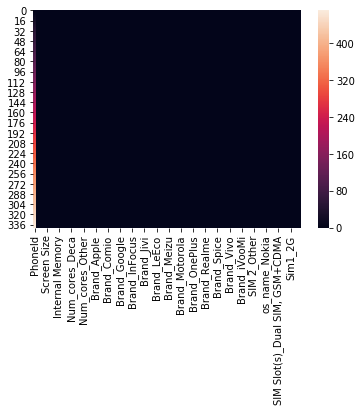

In [34]:
sns.heatmap(train_new)

In [35]:
#X = train_new[['Capacity','Height','Pixel Density', 'Processor_frequency','Resolution','RAM', 'Screen Size','Screen to Body Ratio (calculated)','Internal Memory','Weight' ]]
X = train_new.drop(['PhoneId','Rating'], axis=1)
#X_bin = X.apply(pd.cut, bins=2, labels=[1,0])
y = train_new['Rating']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, )

In [37]:
X_train = X_train.values
X_test = X_test.values

In [38]:
mpneuron =MPNeuron()
mpneuron.fit(X_train, y_train)


 B value : 14
accuracy : 0.7316176470588235


In [39]:
predict =mpneuron.predict(X_test)
accuracy = accuracy_score(predict, y_test)
print(accuracy)

0.7681159420289855


In [40]:
test = test_new.drop('PhoneId', axis=1)

In [41]:
test = test.values

In [42]:
predict =mpneuron.predict(test)

In [43]:
predict = pd.DataFrame(predict, columns=['Rating'], dtype='int')

In [44]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':predict['Rating']})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,1
1,11,1
2,13,1
3,16,1
4,19,1


In [45]:
submission.to_csv("submission.csv", index=False)

### Perceptron Model

In [46]:
class Perceptron:
    def __init__ (self):
        self.w = None
        self.b = None
    def model(self, x):
        return 1 if (np.dot(self.w, x) >= self.b) else 0
    def predict(self, X):
        
        Y = []
        for x in X:
            result = self.model(x)
            Y.append(result)
        return np.array(Y)
    
    def fit(self, X, Y, epochs = 1, lr = 1):
    
        self.w = np.ones(X.shape[1])
        self.b = 0
    
        accuracy = {}
        max_accuracy = 0
    
        wt_matrix = []
    
        for i in range(epochs):
            for x, y in zip(X, Y):
                y_pred = self.model(x)
                if y == 1 and y_pred == 0:
                    self.w = self.w + lr * x
                    self.b = self.b + lr * 1
                elif y == 0 and y_pred == 1:
                    self.w = self.w - lr * x
                    self.b = self.b - lr * 1
            wt_matrix.append(self.w)
            accuracy[i] = accuracy_score(self.predict(X), Y)
            if (accuracy[i] > max_accuracy):
                max_accuracy = accuracy[i]
                chkptw = self.w
                chkptb = self.b
        
        self.w = chkptw
        self.b = chkptb
        
        print(max_accuracy)
        plt.plot(accuracy.values())
        plt.ylim([0, 1])
        plt.show()
    
        return np.array(wt_matrix)

In [47]:
def rate(x):
    if x>= 4.0:
        return 1
    else:
        return 0

In [48]:
#X = train_new[['Capacity','Height','Pixel Density', 'Processor_frequency','Resolution','RAM', 'Screen Size','Screen to Body Ratio (calculated)','Internal Memory','Weight' ]]
X = train_new_1.drop(['PhoneId','Rating'], axis=1)
#X_bin = X.apply(pd.cut, bins=2, labels=[1,0])
y = train_new_1['Rating']
y = y.apply(rate)
perceptron = Perceptron()

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, )

In [50]:
X_train = X_train.values
X_test = X_test.values


0.7683823529411765


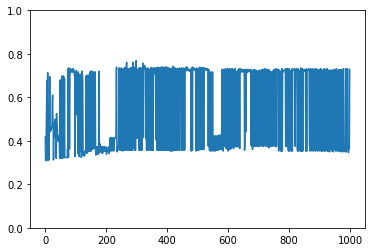

In [51]:
wt_metric =perceptron.fit(X_train, y_train, 1000, 0.01)

In [52]:
y_pred = perceptron.predict(X_test)
accuracy_score(y_test, y_pred)

0.6376811594202898

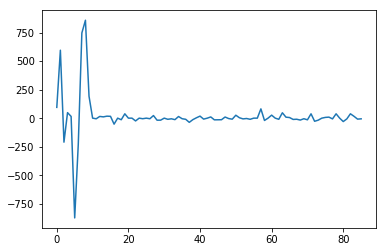

In [53]:
plt.plot(wt_metric[-1, :])

In [54]:
from sklearn.linear_model import LinearRegression

In [55]:
X = train_new_1.drop(['PhoneId','Rating'], axis=1)
#X_bin = X.apply(pd.cut, bins=2, labels=[1,0])
y = train_new_1['Rating']


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, )

In [57]:
lr = LinearRegression()

In [58]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [59]:
y_pred = lr.predict(X_test)

In [60]:
y_pred_1= y_pred.round(decimals=1)

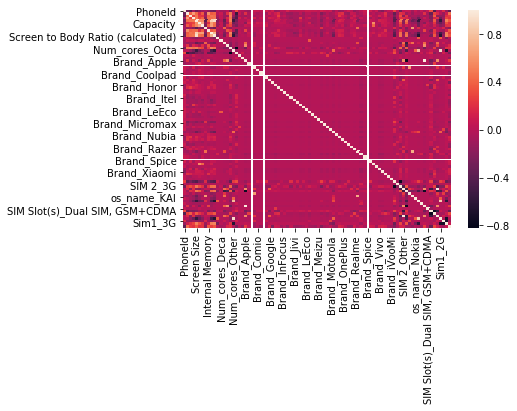

In [61]:
sns.heatmap(train_new_1.corr())

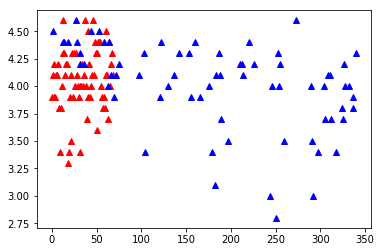

In [62]:
plt.plot(y_pred_1,'r^')
plt.plot(y_test,'b^')

In [63]:
count = 0 
count_1 = 0
count_2 = 0
for x, y in zip(y_pred_1, y_test):
    if x == y:
        count +=1
    elif x> y:
        count_1 += 1
    else:
        count_2 += 1
print(count)
print(count_1)
print(count_2)
print(y_pred.size)

18
23
28
69


In [64]:
for x, y in zip(y_pred_1, y_test):
    print(x, y)

3.9 2.8
4.1 4.3
3.9 3.7
4.2 4.3
3.9 4.0
4.1 4.3
4.1 4.2
4.2 3.4
3.8 3.7
3.4 3.4
3.8 4.0
4.0 4.2
4.3 4.1
4.6 4.6
4.3 3.9
4.1 4.2
4.2 4.0
4.2 4.1
3.3 3.9
3.4 3.4
3.9 4.0
3.5 3.5
4.1 4.0
4.3 4.3
3.9 4.0
4.3 4.0
4.0 3.0
4.3 4.4
4.1 3.8
4.0 3.5
3.9 3.7
3.4 3.4
4.0 4.2
4.0 4.2
4.2 4.4
4.0 4.2
4.1 4.1
4.6 4.6
4.0 4.5
3.7 3.8
3.9 4.1
4.5 4.4
4.2 4.4
3.9 4.0
4.0 4.2
4.1 4.1
4.6 4.5
4.1 4.1
4.4 4.4
4.3 4.2
4.3 4.3
3.6 3.5
4.4 4.4
4.4 4.4
4.4 4.5
4.0 4.3
3.9 4.1
3.8 4.0
3.9 3.9
3.8 3.9
4.5 4.4
4.1 4.1
4.1 3.1
3.7 3.7
4.4 4.4
4.0 3.9
4.2 3.0
4.3 4.1
4.1 4.3


In [65]:
mean_squared_error(y_test, y_pred)

0.10842059862399232

## Decision Tree 

In [66]:
from sklearn.tree import  DecisionTreeRegressor

In [67]:
regressor = DecisionTreeRegressor()

In [68]:
X = train_new_1.drop(['PhoneId','Rating'], axis=1)
#X_bin = X.apply(pd.cut, bins=2, labels=[1,0])
y = train_new_1['Rating']


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, )

In [70]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [71]:
from sklearn import metrics

In [72]:
y_pred = regressor.predict(X_test)

In [73]:
print(metrics.mean_absolute_error(y_test, y_pred ))

0.22898550724637684


In [74]:
mean_squared_error(y_test, y_pred)

0.11478260869565213

In [75]:
count = 0 
count_1 = 0
count_2 = 0
for x, y in zip(y_pred_1.round(1), y_test):
    if x == y:
        count +=1
    elif x> y:
        count_1 += 1
    else:
        count_2 += 1
print(count)
print(count_1)
print(count_2)
print(y_pred.size)

6
33
30
69


## Random Forest

In [76]:
from sklearn.ensemble import RandomForestRegressor

In [77]:
rfg = RandomForestRegressor(n_estimators=20)

In [78]:
X = train_new_1.drop(['PhoneId','Rating'], axis=1)
#X_bin = X.apply(pd.cut, bins=2, labels=[1,0])
y = train_new_1['Rating']


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, )

In [80]:
rfg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [81]:
y_pred_2 = rfg.predict(X_test)

In [82]:
print(metrics.mean_absolute_error(y_test, y_pred_2 ))

0.21420289855072475


In [83]:
mean_squared_error(y_test, y_pred_2)

0.10846666666666668

In [84]:
for x, y in zip(y_pred_2.round(1), y_test):
    print(x, y)

4.3 4.2
4.3 4.3
4.4 4.4
4.1 4.3
3.6 3.4
4.3 4.3
4.3 4.5
4.1 4.4
4.0 4.0
4.1 3.9
3.9 3.9
3.8 3.8
4.1 4.3
4.4 4.4
4.4 4.4
4.5 4.5
4.1 4.4
4.1 3.1
4.0 4.2
4.2 4.3
3.9 4.1
4.0 3.9
3.8 2.8
4.4 4.3
3.7 3.4
4.5 4.6
4.0 4.0
4.0 4.4
4.2 3.6
4.0 4.3
4.3 4.3
4.1 4.3
3.9 4.8
4.1 4.1
3.8 3.5
4.3 3.9
4.2 4.4
4.6 4.6
4.0 3.6
4.1 3.9
4.0 3.9
3.9 3.6
4.5 4.5
4.2 4.3
4.0 4.1
4.0 3.9
4.3 4.3
4.3 4.3
3.6 4.1
4.1 4.2
3.5 3.7
3.6 3.4
3.8 4.2
4.0 4.1
4.1 4.3
4.1 4.3
4.2 4.3
3.9 3.5
3.9 3.9
4.2 4.3
4.4 4.3
3.9 4.0
4.0 4.3
4.0 4.2
3.7 4.0
4.2 3.0
3.5 4.1
4.3 4.4
4.2 4.1


In [85]:
count = 0 
count_1 = 0
count_2 = 0
for x, y in zip(y_pred_2.round(1), y_test):
    if x == y:
        count +=1
    elif x> y:
        count_1 += 1
    else:
        count_2 += 1
print(count)
print(count_1)
print(count_2)
print(y_pred.size)

17
21
31
69


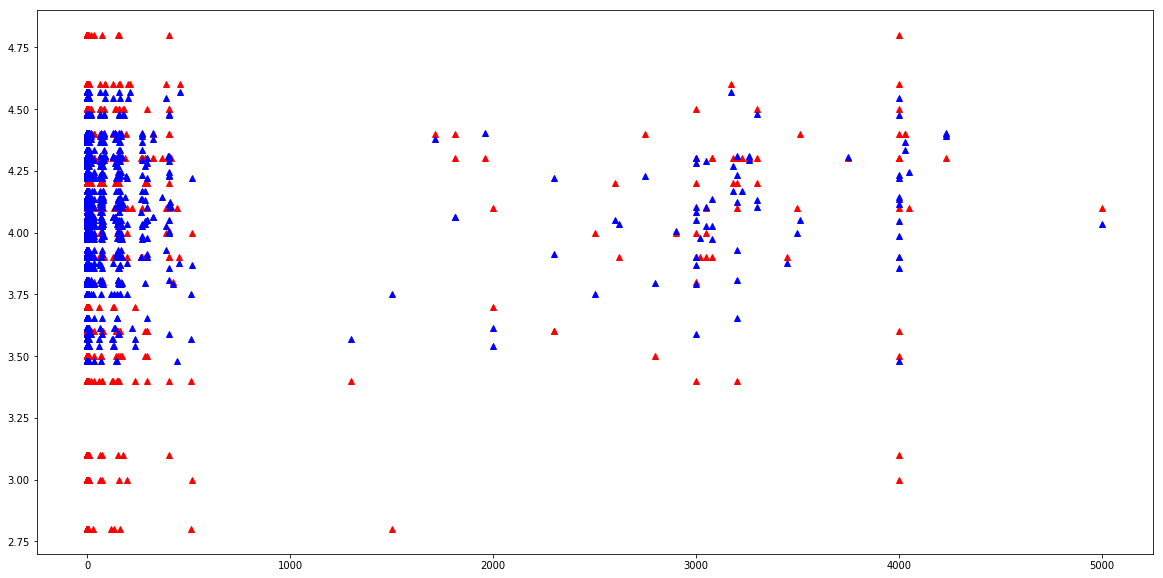

In [86]:
plt.figure(figsize=(20,10))
plt.plot(X_test, y_test, 'r^',)
plt.plot(X_test, y_pred_2, 'b^')

## Sigmoid Neuron

In [87]:
class SigmoidNeuron:
    
    def __init__(self):
        self.w = None
        self.b = None
        
    def perceptron(self, x):
        return np.dot(x, self.w.T) + self.b
    
    def sigmoid(self,x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def grad_w(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1- y_pred) *x
    
    def grad_b(self,x,y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred) 
    
    def fit(self, X,Y, epochs =1, learning_rate = 1, initialise = True, display_loss = False):
        if initialise:
            self.w = np.random.rand(1,X.shape[1])
            self.b = 0
            
        if display_loss:
            loss = {}
        
        for i in tqdm_notebook(range(epochs), total = epochs, unit='epoch'):
            dw = 0
            db = 0
            
            for x, y in zip(X,Y):
                dw += self.grad_w(x, y)
                db += self.grad_b(x,y)
                
            self.w -= learning_rate * dw
            self.b -= learning_rate * db
        
            if display_loss:
                Y_pred = self.sigmoid(self.perceptron(X))
                loss[i]  = mean_squared_error(Y_pred, Y)
        if display_loss:
            plt.plot(loss.values())
            plt.xlabel('Epoche')
            plt.ylabel('Mean Sq error')
            plt.show()
            
    def predict(self,X):
        Y_pred = []
        for x in X:
            y_pred = self.sigmoid(self.perceptron(x))
            Y_pred.append(y_pred)
        return np.array(Y_pred)
    
            

In [88]:
import matplotlib.colors
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [89]:
sigmoid = SigmoidNeuron()

In [90]:
X = train_new_1.drop(['PhoneId','Rating'], axis=1)
#X_bin = X.apply(pd.cut, bins=2, labels=[1,0])
y = train_new_1['Rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, )

In [91]:
scaler = StandardScaler()

In [92]:
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\shubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  


In [93]:
minmax_scaler = MinMaxScaler()

In [94]:
Y_scaled_train = minmax_scaler.fit_transform(y_train.reshape(-1, 1))

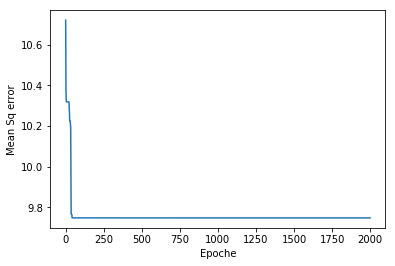

In [95]:
sigmoid.fit(X_scaled_train, y_train, epochs=2000, learning_rate=0.15, display_loss=True)

In [96]:
Y_pred_train = sigmoid.predict(X_scaled_train)
Y_pred_test = sigmoid.predict(X_scaled_test)


In [97]:
Y_scaled_test = minmax_scaler.transform(y_test.reshape(-1, 1))

In [98]:
threshold = 4.2
scaled_threshold = list(minmax_scaler.transform(np.array([threshold]).reshape(1, -1)))[0][0]

In [99]:
scaled_threshold

0.6800000000000002

In [100]:
Y_binarised_train = (Y_scaled_train > scaled_threshold).astype("int").ravel()
Y_binarised_test = (Y_scaled_test > scaled_threshold).astype("int").ravel()
Y_pred_binarised_train = (Y_pred_train > scaled_threshold).astype("int").ravel()
Y_pred_binarised_test = (Y_pred_test > scaled_threshold).astype("int").ravel()

In [101]:
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_binarised_train)
accuracy_test  = accuracy_score(Y_pred_binarised_test, Y_binarised_test)

In [102]:
accuracy_train

0.4007352941176471

In [103]:
accuracy_test

0.34782608695652173

## Feed Forword Neuron